In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fungsi untuk mengimpor data dari file teks dan mengabaikan header atau metadata
def impor_data(nama_file):
    kota = []
    with open(nama_file, 'r') as file:
        for baris in file.readlines():
            # Mengabaikan baris yang berisi metadata (seperti "NAME:", "TYPE:", dll)
            if baris.startswith("NAME") or baris.startswith("TYPE") or baris.startswith("COMMENT") or baris.startswith("EDGE_WEIGHT_TYPE"):
                continue
            # Mengabaikan baris kosong
            if not baris.strip():
                continue
            # Mengambil data koordinat kota
            data = baris.split()
            try:
                id_kota = int(data[0])  # ID kota
                x = float(data[1])       # Koordinat X
                y = float(data[2])       # Koordinat Y
                kota.append((id_kota, x, y))
            except ValueError:
                # Jika terjadi error dalam konversi data, lewati baris tersebut
                continue
    return kota

In [3]:
# Fungsi untuk menghitung jarak antara dua kota menggunakan rumus Euclidean
def hitung_jarak(kota1, kota2):
    return np.sqrt((kota1[1] - kota2[1])**2 + (kota1[2] - kota2[2])**2)

In [4]:
class ACO:
    def __init__(self, kota, max_evaluasi=5000, jumlah_semut=30, evaluasi_per_run=50, alpha=1, beta=5, rho=0.1):
        self.kota = kota
        self.max_evaluasi = max_evaluasi
        self.jumlah_semut = jumlah_semut
        self.evaluasi_per_run = evaluasi_per_run
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.jarak = self.hitung_matriks_jarak()
        self.pheromone = np.ones((len(kota), len(kota)))
        self.solusi_terbaik = [] # Solusi terbaik harus berupa list indeks kota
        self.jarak_terbaik = float('inf')

    def hitung_matriks_jarak(self):
        n = len(self.kota)
        matriks_jarak = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                matriks_jarak[i][j] = hitung_jarak(self.kota[i], self.kota[j])
        return matriks_jarak

    def jalankan_aco(self):
        evaluasi = 0  # Menghitung jumlah evaluasi
        hasil_jarak_terbaik = []  # Menyimpan jarak terbaik dari setiap evaluasi

        while evaluasi < self.max_evaluasi:
            solusi = self.solusi_semut()  # Mendapatkan solusi semut
            evaluasi += self.evaluasi_per_run  # Tambahkan evaluasi per run (50 evaluasi)
            hasil_jarak_terbaik.append(self.jarak_terbaik)

            # Print detail percobaan setiap evaluasi
            print(f"Evaluasi: {evaluasi}, Jarak Terbaik: {self.jarak_terbaik}")
            print(f"Jalur Terbaik: [{', '.join(map(str, self.solusi_terbaik))}]")

            # Memastikan total evaluasi mencapai 5000
            if evaluasi >= self.max_evaluasi:
                print(f"Total evaluasi telah mencapai batas: {self.max_evaluasi} evaluasi.")
                break  # Hentikan jika evaluasi sudah mencapai batas maksimal

            self.perbarui_pheromone(solusi)  # Update pheromone setelah solusi ditemukan

        # Menghitung nilai terbaik, rata-rata dan standar deviasi dari hasil percobaan
        terbaik = min(hasil_jarak_terbaik)
        rata_rata = np.mean(hasil_jarak_terbaik)
        std_deviasi = np.std(hasil_jarak_terbaik)

        return terbaik, rata_rata, std_deviasi, hasil_jarak_terbaik

    def solusi_semut(self):
        dikunjungi = [False] * len(self.kota)
        jalur = []
        total_jarak = 0
        mulai = np.random.randint(len(self.kota))  # Kota awal dipilih secara acak
        jalur.append(mulai)
        dikunjungi[mulai] = True

        while len(jalur) < len(self.kota):
            kota_sekarang = jalur[-1]
            kota_selanjutnya = self.pilih_kota_selanjutnya(kota_sekarang, dikunjungi)
            jalur.append(kota_selanjutnya)
            dikunjungi[kota_selanjutnya] = True
            total_jarak += self.jarak[kota_sekarang][kota_selanjutnya]

        total_jarak += self.jarak[jalur[-1]][jalur[0]]  # Kembali ke kota asal

        if total_jarak < self.jarak_terbaik:
            self.jarak_terbaik = total_jarak
            self.solusi_terbaik = jalur  # Simpan urutan indeks kota yang dikunjungi

        return jalur

    def pilih_kota_selanjutnya(self, kota_sekarang, dikunjungi):
        probabilitas = []
        for i in range(len(self.kota)):
            if not dikunjungi[i]:
                tau = self.pheromone[kota_sekarang][i] ** self.alpha
                eta = (1.0 / self.jarak[kota_sekarang][i]) ** self.beta
                probabilitas.append(tau * eta)
            else:
                probabilitas.append(0)

        total_probabilitas = sum(probabilitas)
        probabilitas = [p / total_probabilitas for p in probabilitas]
        kota_selanjutnya = np.random.choice(len(self.kota), p=probabilitas)
        return kota_selanjutnya

    def perbarui_pheromone(self, jalur):
        for i in range(len(jalur) - 1):
            self.pheromone[jalur[i]][jalur[i + 1]] += 1.0 / self.jarak[jalur[i]][jalur[i + 1]]
        self.pheromone *= (1 - self.rho)


In [5]:
# Fungsi untuk visualisasi titik kota (tanpa jalur)
def visualisasi_titik(kota, judul):
    x = [t[1] for t in kota]
    y = [t[2] for t in kota]

    # Membuat plot dengan ukuran yang lebih besar
    plt.figure(figsize=(12, 10))

    # Menampilkan titik kota
    plt.scatter(x, y, c='red', marker='o', s=100, label="Kota")

    # Memberi label pada setiap titik kota
    for i, t in enumerate(kota):
        plt.annotate(str(t[0]), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

    # Menambahkan judul dan label sumbu
    plt.title(f"Visualisasi Titik Kota - {judul}", fontsize=16)
    plt.xlabel("Koordinat X", fontsize=12)
    plt.ylabel("Koordinat Y", fontsize=12)

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan plot
    plt.legend()
    plt.show()

In [6]:
# Fungsi untuk visualisasi titik dan jalur terbaik sesuai dengan solusi terbaik
def visualisasi_titik_dan_jalur(kota, solusi_terbaik, judul):
    print(f"Debug: Solusi terbaik yang diterima: {solusi_terbaik}")  # Debugging untuk solusi terbaik

    # Memastikan solusi terbaik adalah list yang berisi indeks kota
    if isinstance(solusi_terbaik, list):
        print(f"Solusi terbaik valid! Jumlah kota: {len(solusi_terbaik)}")

        # Menyiapkan koordinat X dan Y kota
        x = [t[1] for t in kota]  # Koordinat X kota
        y = [t[2] for t in kota]  # Koordinat Y kota

        # Membuat plot dengan ukuran yang lebih besar
        plt.figure(figsize=(14, 12))

        # Menampilkan titik kota
        plt.scatter(x, y, c='red', marker='o', s=100, label="Kota")

        # Memberi label pada setiap titik kota
        for i, t in enumerate(kota):
            plt.annotate(str(t[0]), (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

        # Menyesuaikan solusi terbaik untuk dataset yang dimulai dari 0
        # Mengurangi 1 pada setiap indeks agar cocok dengan dataset yang dimulai dari 0
        solusi_terbaik_adjusted = [idx - 1 for idx in solusi_terbaik]

        # Menampilkan jalur terbaik berdasarkan solusi ACO
        jalur_x = []
        jalur_y = []

        # Ambil koordinat dari kota-kota sesuai urutan solusi terbaik yang sudah disesuaikan
        for idx in solusi_terbaik_adjusted:
            jalur_x.append(kota[idx][1])  # Menambahkan koordinat X kota
            jalur_y.append(kota[idx][2])  # Menambahkan koordinat Y kota

        # Menyambung jalur kembali ke titik awal (terakhir ke pertama)
        jalur_x.append(kota[solusi_terbaik_adjusted[0]][1])  # Menyambung ke titik pertama
        jalur_y.append(kota[solusi_terbaik_adjusted[0]][2])  # Menyambung ke titik pertama

        # Plot jalur terbaik
        plt.plot(jalur_x, jalur_y, color='blue', linewidth=2, label="Jalur Terbaik")

        # Menambahkan judul dan label sumbu
        plt.title(f"Visualisasi Titik dan Jalur Terbaik - {judul}", fontsize=16)
        plt.xlabel("Koordinat X", fontsize=12)
        plt.ylabel("Koordinat Y", fontsize=12)

        # Menampilkan grid
        plt.grid(True)

        # Menampilkan plot
        plt.legend()
        plt.show()

    else:
        print("Solusi terbaik tidak valid. Pastikan itu adalah list indeks kota.")
        print(f"Solusi terbaik yang diterima: {solusi_terbaik}")  # Menampilkan solusi terbaik yang diterima


In [7]:
def visualisasi_hasil(hasil_eksperimen, run_count, judul):
    # Membuat plot untuk setiap run eksperimen
    plt.figure(figsize=(12, 6))

    # Plotkan setiap run eksperimen
    for run in range(run_count):
        hasil_run = hasil_eksperimen[run][3]  # Ambil hanya jarak terbaik dari hasil eksperimen run
        evaluasi_run_x = [i * 50 for i in range(1, len(hasil_run) + 1)]  # Evaluasi bertahap per run

        # Menampilkan hasil eksperimen per run
        plt.plot(evaluasi_run_x, hasil_run, label=f'Run {run + 1}', marker='o', markersize=5)

    # Menambahkan garis horizontal untuk menandakan jarak terbaik yang didapat (minimum jarak)
    min_jarak = min([min(run[3]) for run in hasil_eksperimen])  # Jarak terbaik dari seluruh eksperimen
    plt.axhline(y=min_jarak, color='r', linestyle='--', label="Jarak Terbaik")

    # Menambahkan judul dan label sumbu
    plt.title(f"Visualisasi Hasil ACO - {judul}", fontsize=16)
    plt.xlabel("Evaluasi", fontsize=12)
    plt.ylabel("Jarak Total", fontsize=12)

    # Menyesuaikan batas evaluasi hingga 5000
    plt.xlim(0, 5000)  # Sumbu X dari 0 hingga 5000

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan legenda
    plt.legend()

    # Menampilkan plot
    plt.show()


In [8]:
# Fungsi untuk menjalankan eksperimen pada dataset
def eksperimen(kota):
    aco = ACO(kota)
    terbaik, rata_rata, std_deviasi, hasil_jarak_terbaik = aco.jalankan_aco()
    return aco, terbaik, rata_rata, std_deviasi, hasil_jarak_terbaik

In [9]:
def eksperimen_multiple(kota, run_count=10):
    semua_hasil = []
    solusi_terbaik_seluruh_run = []  # Menyimpan solusi terbaik dari setiap run

    for run in range(run_count):
        print(f"\n--- Percobaan {run + 1} ---")
        aco, terbaik, rata_rata, std_deviasi, hasil_jarak_terbaik = eksperimen(kota)
        semua_hasil.append((terbaik, rata_rata, std_deviasi, hasil_jarak_terbaik))

        # Simpan solusi terbaik setiap percobaan
        solusi_terbaik_seluruh_run.append(aco.solusi_terbaik)

    # Menghitung nilai terbaik, rata-rata dan standar deviasi dari seluruh run
    terbaik_total = min([hasil[0] for hasil in semua_hasil])
    rata_rata_total = np.mean([hasil[1] for hasil in semua_hasil])
    std_deviasi_total = np.std([hasil[2] for hasil in semua_hasil])

    print(f"\nHasil Akhir Semua Percobaan:")
    print(f"Jarak Terbaik Total: {terbaik_total}, Rata-rata Total: {rata_rata_total}, Std Deviasi Total: {std_deviasi_total}")

    # Menentukan solusi terbaik dari seluruh eksperimen
    solusi_terbaik_akhir = solusi_terbaik_seluruh_run[np.argmin([hasil[0] for hasil in semua_hasil])]

    # Menyesuaikan solusi terbaik agar indeks kota dimulai dari 1
    solusi_terbaik_akhir_adjusted = [idx + 1 for idx in solusi_terbaik_akhir]

    jalurbaik_total = ', '.join(map(str, solusi_terbaik_akhir_adjusted))  # Menggunakan solusi terbaik yang sudah disesuaikan
    print(f"Jalur Terbaik Seluruh Run (Disesuaikan): {jalurbaik_total}")

    return jalurbaik_total, terbaik_total, rata_rata_total, std_deviasi_total, semua_hasil, solusi_terbaik_akhir_adjusted  # Mengembalikan solusi terbaik yang sudah disesuaikan

In [10]:
# Menjalankan eksperimen untuk Berlin52, KroA100, dan ch150
kota_berlin52 = impor_data('berlin52.txt')  # Ganti dengan path file Berlin52
kota_kroa100 = impor_data('kroa100.txt')    # Ganti dengan path file KroA100
kota_ch150 = impor_data('ch150.txt')        # Ganti dengan path file ch150

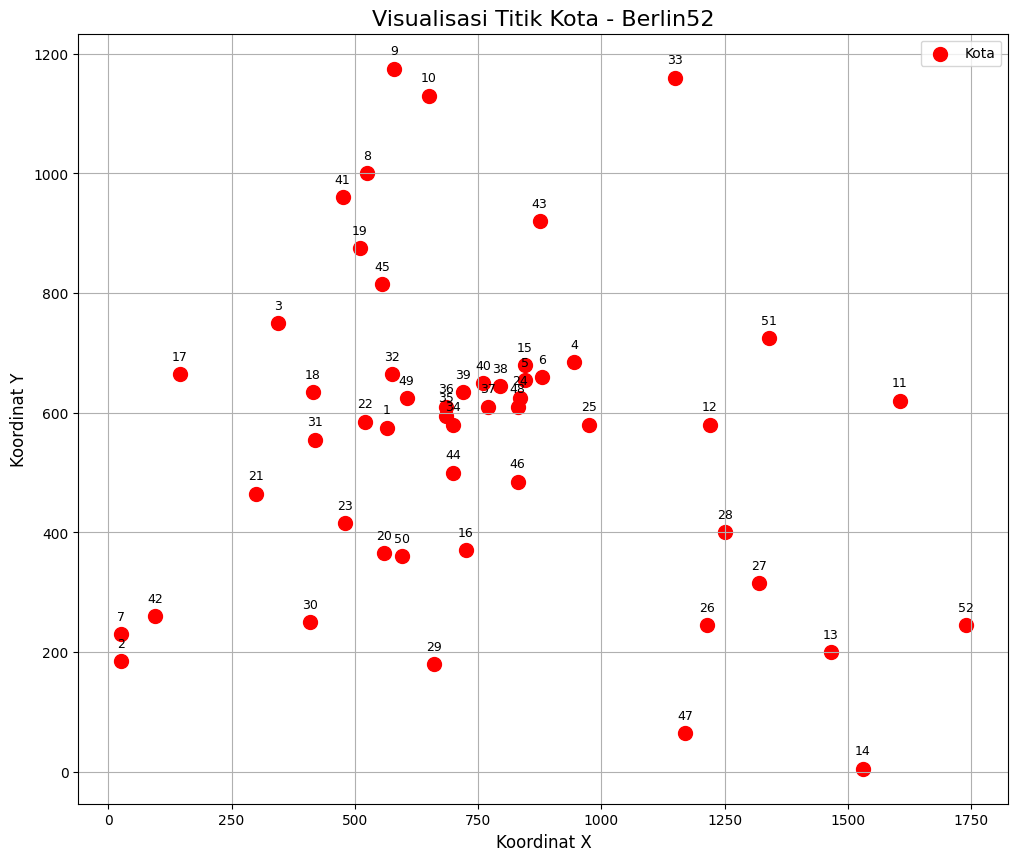

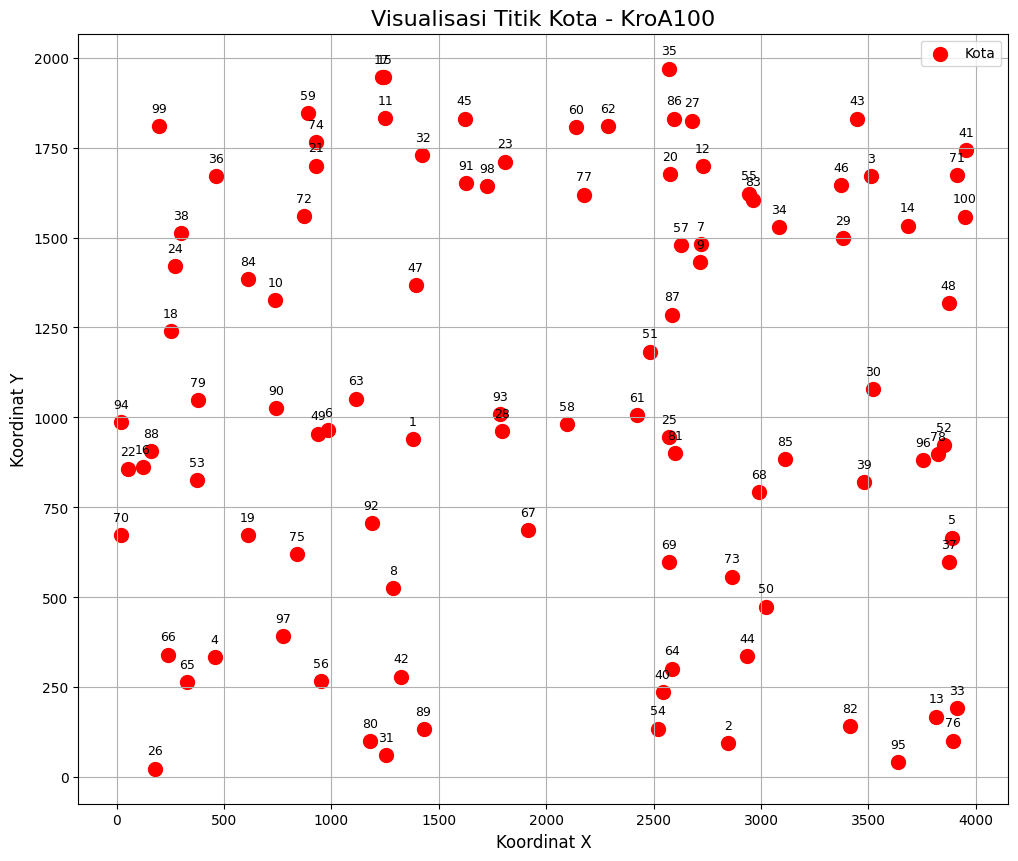

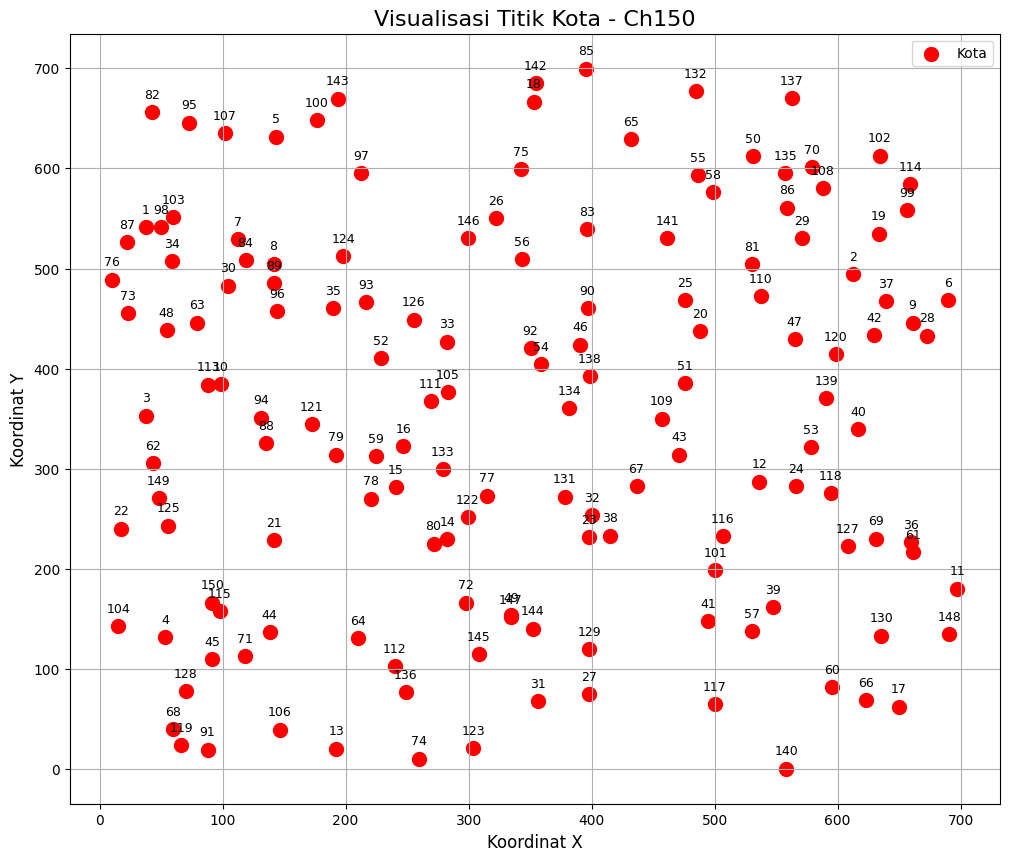

In [11]:
# Menampilkan visualisasi titik kota untuk masing-masing dataset
visualisasi_titik(kota_berlin52, "Berlin52")
visualisasi_titik(kota_kroa100, "KroA100")
visualisasi_titik(kota_ch150, "Ch150")

In [12]:
solusi_terbaik_berlin52, terbaik_berlin52, rata_rata_berlin52, std_deviasi_berlin52, hasil_berlin52, solusi_terbaik_akhir_berlin52 = eksperimen_multiple(kota_berlin52)


--- Percobaan 1 ---
Evaluasi: 50, Jarak Terbaik: 10398.062525715553
Jalur Terbaik: [27, 26, 25, 46, 42, 3, 5, 14, 4, 23, 47, 36, 39, 37, 38, 35, 34, 33, 43, 45, 15, 49, 19, 22, 0, 48, 31, 44, 18, 40, 7, 8, 9, 17, 30, 21, 2, 16, 41, 1, 6, 29, 20, 28, 24, 11, 10, 50, 32, 12, 13, 51]
Evaluasi: 100, Jarak Terbaik: 10313.822991180912
Jalur Terbaik: [1, 6, 41, 29, 22, 49, 19, 15, 45, 47, 23, 4, 14, 5, 37, 39, 38, 35, 34, 33, 36, 48, 31, 21, 0, 43, 24, 3, 42, 32, 13, 12, 25, 26, 27, 11, 50, 10, 51, 46, 28, 30, 17, 20, 16, 2, 44, 18, 40, 7, 8, 9]
Evaluasi: 150, Jarak Terbaik: 10259.061851939423
Jalur Terbaik: [33, 34, 35, 31, 48, 0, 21, 30, 17, 20, 16, 2, 40, 7, 18, 44, 38, 39, 37, 23, 47, 4, 14, 5, 3, 24, 45, 36, 43, 15, 49, 19, 22, 29, 41, 1, 6, 28, 25, 26, 27, 12, 13, 51, 10, 50, 11, 32, 42, 9, 8, 46]
Evaluasi: 200, Jarak Terbaik: 10259.061851939423
Jalur Terbaik: [33, 34, 35, 31, 48, 0, 21, 30, 17, 20, 16, 2, 40, 7, 18, 44, 38, 39, 37, 23, 47, 4, 14, 5, 3, 24, 45, 36, 43, 15, 49, 19, 22, 

In [13]:
solusi_terbaik_kroa100, terbaik_kroa100, rata_rata_kroa100, std_deviasi_kroa100, hasil_kroa100, solusi_terbaik_akhir_kroa100= eksperimen_multiple(kota_kroa100)


--- Percobaan 1 ---
Evaluasi: 50, Jarak Terbaik: 35363.11342795793
Jalur Terbaik: [16, 14, 10, 31, 44, 97, 22, 90, 54, 82, 33, 28, 2, 45, 42, 13, 70, 40, 99, 47, 38, 95, 77, 51, 4, 36, 32, 75, 12, 94, 81, 49, 43, 72, 68, 80, 24, 60, 56, 6, 8, 86, 50, 19, 26, 85, 34, 11, 59, 76, 61, 57, 92, 27, 0, 62, 48, 5, 89, 18, 52, 15, 87, 93, 21, 69, 65, 64, 3, 96, 55, 79, 30, 88, 41, 7, 91, 74, 17, 23, 37, 35, 83, 9, 78, 71, 20, 73, 58, 98, 46, 67, 84, 63, 39, 1, 53, 66, 29, 25]
Evaluasi: 100, Jarak Terbaik: 32995.308402166535
Jalur Terbaik: [65, 64, 3, 96, 55, 74, 18, 52, 78, 87, 15, 21, 93, 69, 23, 37, 35, 98, 73, 20, 71, 83, 9, 89, 5, 48, 62, 46, 31, 10, 14, 16, 90, 44, 97, 22, 76, 59, 61, 85, 11, 56, 8, 6, 26, 34, 54, 82, 33, 29, 38, 95, 77, 51, 36, 4, 12, 75, 32, 94, 81, 49, 43, 1, 72, 84, 67, 24, 80, 60, 50, 86, 19, 66, 41, 79, 30, 88, 7, 91, 0, 92, 27, 57, 68, 63, 39, 53, 45, 28, 2, 42, 13, 70, 40, 99, 47, 17, 58, 25]
Evaluasi: 150, Jarak Terbaik: 32995.308402166535
Jalur Terbaik: [65, 64

In [14]:
solusi_terbaik_ch150, terbaik_ch150, rata_rata_ch150, std_deviasi_ch150, hasil_ch150, solusi_terbaik_akhir_ch150 = eksperimen_multiple(kota_ch150)


--- Percobaan 1 ---
Evaluasi: 50, Jarak Terbaik: 9539.14203552208
Jalur Terbaik: [111, 135, 63, 114, 149, 44, 70, 43, 3, 105, 12, 73, 122, 30, 26, 128, 143, 146, 48, 144, 71, 79, 13, 121, 76, 132, 14, 77, 58, 15, 78, 120, 32, 125, 51, 110, 104, 91, 53, 45, 137, 133, 50, 108, 42, 66, 31, 37, 22, 130, 82, 140, 80, 109, 28, 85, 134, 69, 107, 18, 98, 113, 101, 119, 46, 8, 27, 41, 36, 1, 57, 54, 49, 136, 131, 84, 141, 17, 55, 25, 145, 89, 19, 24, 52, 23, 11, 117, 126, 68, 35, 60, 10, 147, 129, 16, 65, 59, 139, 116, 40, 56, 38, 100, 115, 138, 39, 5, 87, 93, 9, 112, 62, 47, 72, 75, 86, 0, 97, 102, 33, 6, 83, 29, 88, 7, 95, 123, 34, 92, 96, 4, 99, 142, 106, 94, 81, 74, 64, 148, 21, 124, 61, 2, 20, 103, 127, 67, 118, 90]
Evaluasi: 100, Jarak Terbaik: 9362.081178534474
Jalur Terbaik: [74, 25, 145, 55, 91, 53, 137, 133, 22, 37, 31, 130, 66, 42, 108, 50, 19, 24, 80, 109, 46, 119, 36, 8, 27, 5, 41, 1, 18, 98, 113, 49, 134, 69, 107, 85, 28, 57, 54, 140, 82, 89, 45, 110, 104, 132, 76, 121, 13, 79, 7

In [15]:
# Menampilkan hasil eksperimen
print("\nHasil Akhir Setelah 10 Percobaan:")
print(f"Berlin52 - Terbaik: {terbaik_berlin52}, Rata-rata: {rata_rata_berlin52}, Std Deviasi: {std_deviasi_berlin52}")
print(f"KroA100 - Terbaik: {terbaik_kroa100}, Rata-rata: {rata_rata_kroa100}, Std Deviasi: {std_deviasi_kroa100}")
print(f"Ch150 - Terbaik: {terbaik_ch150}, Rata-rata: {rata_rata_ch150}, Std Deviasi: {std_deviasi_ch150}")

print("\nUrutan Jalur Solusi Terbaik:")
# # Menampilkan jalur solusi terbaik dari setiap percobaan, mengakses solusi terbaik dari hasil percobaan
print(f"Berlin52 - {solusi_terbaik_berlin52}") # Hasil pertama dari percobaan
print(f"KroA100 - {solusi_terbaik_kroa100}")  # Hasil pertama dari percobaan
print(f"Ch150 - {solusi_terbaik_ch150}")  # Hasil pertama dari percobaan


Hasil Akhir Setelah 10 Percobaan:
Berlin52 - Terbaik: 7948.303433599698, Rata-rata: 9100.730163825898, Std Deviasi: 94.22358545815811
KroA100 - Terbaik: 24221.534171422998, Rata-rata: 27307.37025563712, Std Deviasi: 414.0244138314944
Ch150 - Terbaik: 7271.545753786481, Rata-rata: 8314.459705853162, Std Deviasi: 59.504797189849455

Urutan Jalur Solusi Terbaik:
Berlin52 - 46, 44, 34, 35, 36, 39, 40, 38, 37, 48, 24, 5, 15, 6, 4, 25, 12, 28, 27, 26, 47, 13, 14, 52, 11, 51, 33, 43, 10, 9, 8, 41, 19, 45, 32, 49, 1, 22, 31, 18, 3, 17, 21, 30, 42, 7, 2, 20, 50, 23, 29, 16
KroA100 - 29, 46, 3, 43, 14, 48, 100, 71, 41, 78, 52, 96, 5, 37, 33, 76, 13, 95, 82, 50, 44, 2, 40, 64, 54, 69, 81, 25, 61, 51, 87, 9, 7, 57, 20, 12, 27, 86, 35, 62, 60, 77, 23, 98, 91, 45, 32, 11, 15, 17, 59, 74, 21, 72, 10, 84, 36, 99, 38, 24, 18, 79, 53, 19, 75, 97, 56, 80, 31, 89, 42, 8, 92, 1, 63, 6, 49, 90, 88, 16, 22, 94, 70, 66, 65, 4, 26, 47, 93, 28, 67, 58, 73, 68, 85, 39, 30, 34, 83, 55
Ch150 - 127, 69, 36, 61, 11

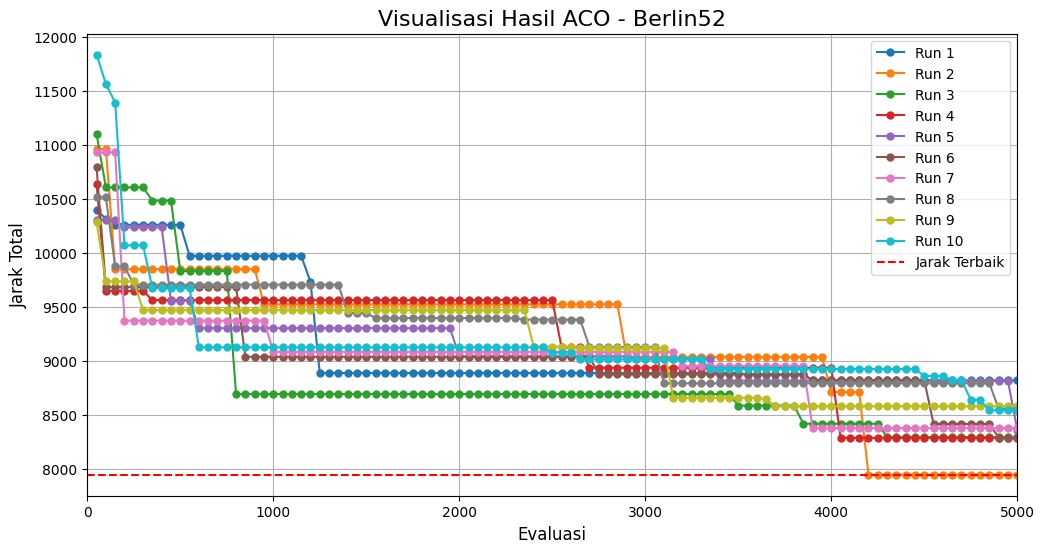

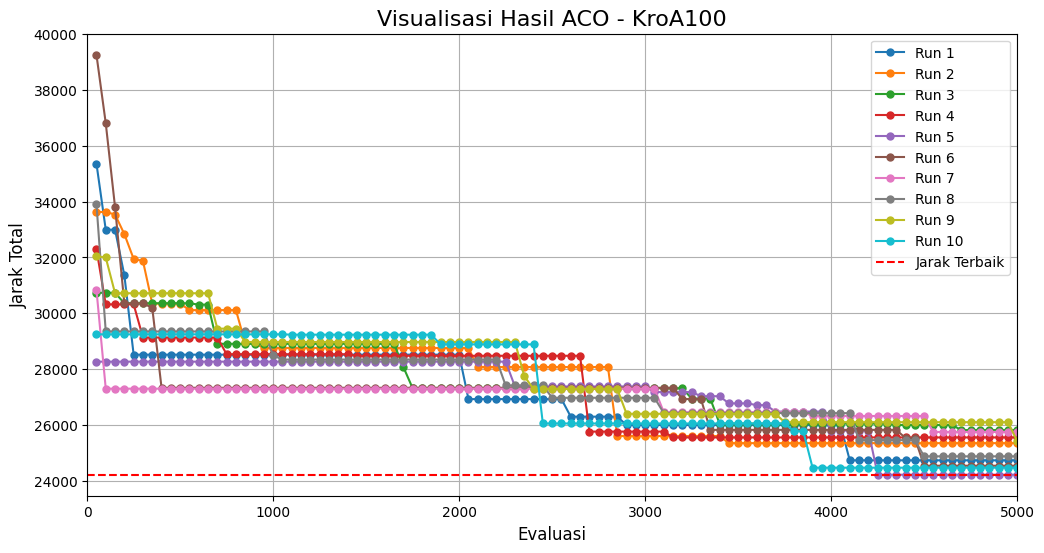

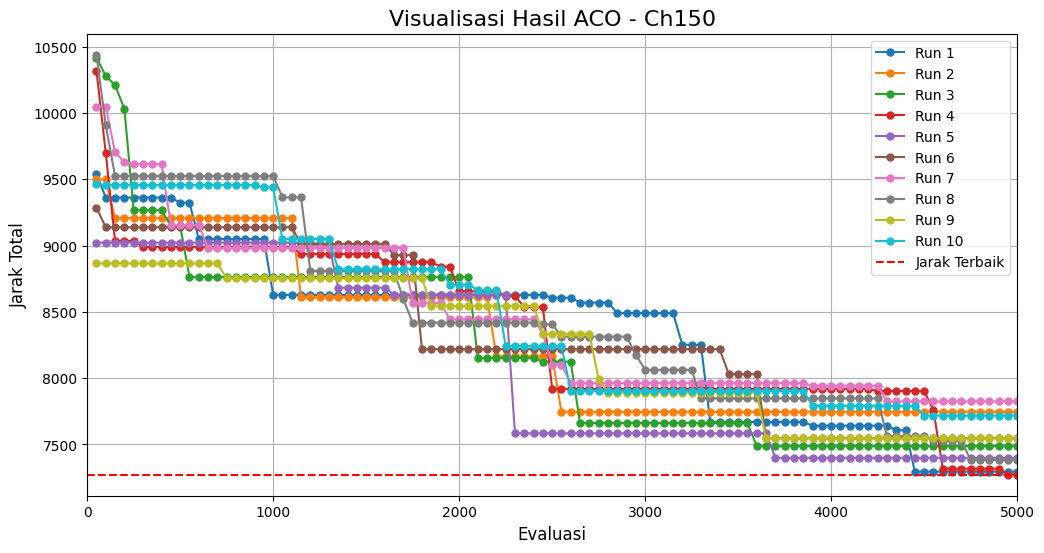

In [16]:
# Visualisasi hasil eksperimen untuk Berlin52, KroA100, dan ch150
visualisasi_hasil(hasil_berlin52, run_count=10, judul="Berlin52")
visualisasi_hasil(hasil_kroa100, run_count=10, judul="KroA100")
visualisasi_hasil(hasil_ch150, run_count=10, judul="Ch150")


Debug: Solusi terbaik yang diterima: [46, 44, 34, 35, 36, 39, 40, 38, 37, 48, 24, 5, 15, 6, 4, 25, 12, 28, 27, 26, 47, 13, 14, 52, 11, 51, 33, 43, 10, 9, 8, 41, 19, 45, 32, 49, 1, 22, 31, 18, 3, 17, 21, 30, 42, 7, 2, 20, 50, 23, 29, 16]
Solusi terbaik valid! Jumlah kota: 52


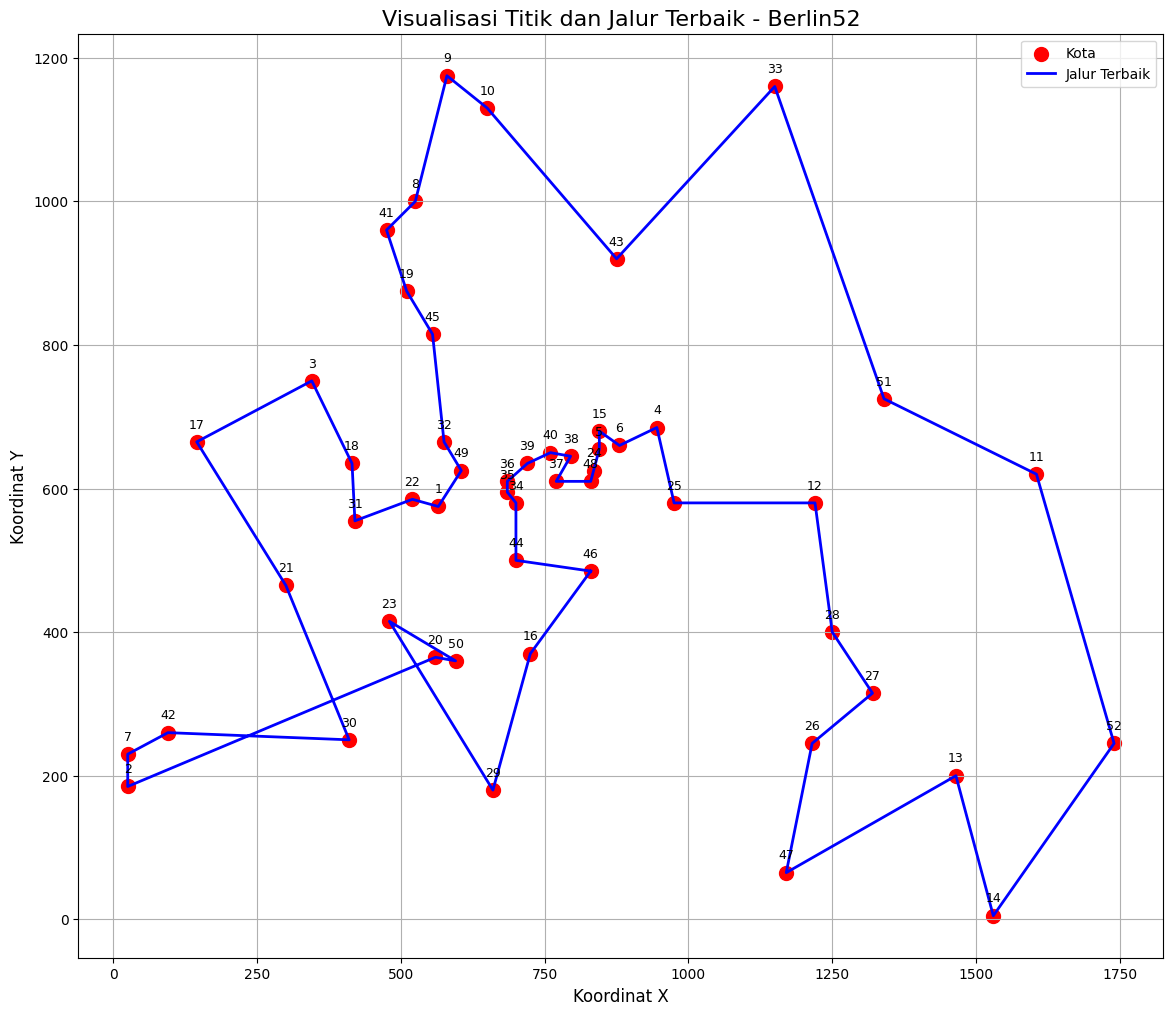

Debug: Solusi terbaik yang diterima: [29, 46, 3, 43, 14, 48, 100, 71, 41, 78, 52, 96, 5, 37, 33, 76, 13, 95, 82, 50, 44, 2, 40, 64, 54, 69, 81, 25, 61, 51, 87, 9, 7, 57, 20, 12, 27, 86, 35, 62, 60, 77, 23, 98, 91, 45, 32, 11, 15, 17, 59, 74, 21, 72, 10, 84, 36, 99, 38, 24, 18, 79, 53, 19, 75, 97, 56, 80, 31, 89, 42, 8, 92, 1, 63, 6, 49, 90, 88, 16, 22, 94, 70, 66, 65, 4, 26, 47, 93, 28, 67, 58, 73, 68, 85, 39, 30, 34, 83, 55]
Solusi terbaik valid! Jumlah kota: 100


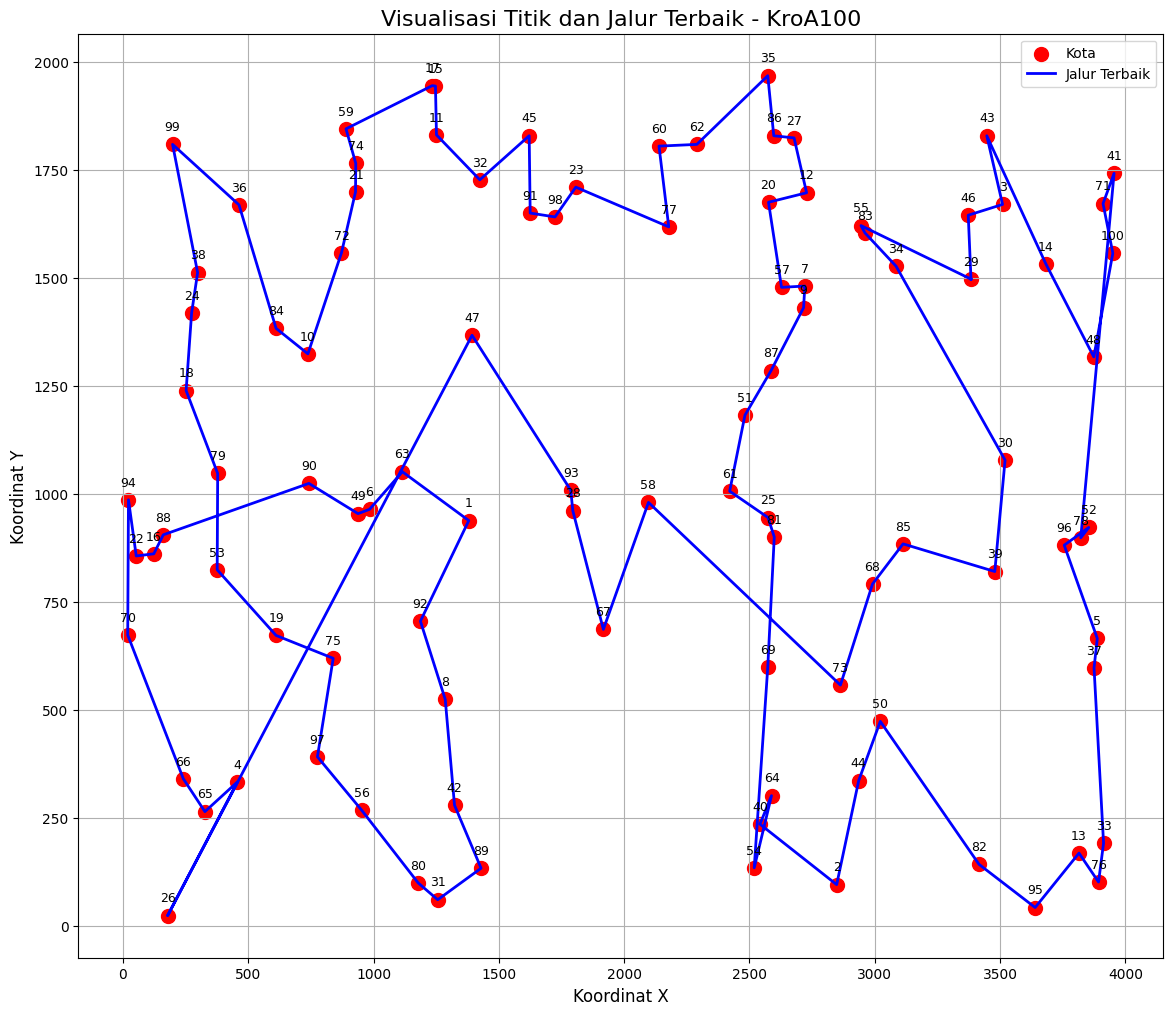

Debug: Solusi terbaik yang diterima: [127, 69, 36, 61, 11, 148, 130, 66, 60, 17, 140, 117, 57, 39, 41, 101, 116, 12, 24, 118, 53, 40, 139, 120, 42, 9, 28, 6, 37, 2, 19, 99, 114, 102, 70, 108, 86, 135, 50, 58, 55, 141, 25, 20, 51, 109, 43, 67, 32, 23, 38, 131, 77, 122, 14, 80, 72, 49, 147, 144, 129, 27, 31, 123, 74, 13, 106, 91, 119, 68, 128, 45, 71, 44, 115, 150, 4, 104, 22, 149, 125, 62, 3, 113, 10, 94, 88, 121, 79, 59, 16, 133, 15, 78, 21, 64, 112, 136, 145, 33, 126, 93, 35, 96, 89, 8, 84, 7, 30, 63, 48, 73, 76, 87, 1, 98, 103, 34, 107, 95, 82, 5, 100, 143, 97, 124, 52, 105, 111, 134, 138, 46, 54, 92, 90, 56, 83, 26, 146, 75, 18, 142, 85, 65, 132, 137, 29, 81, 110, 47]
Solusi terbaik valid! Jumlah kota: 150


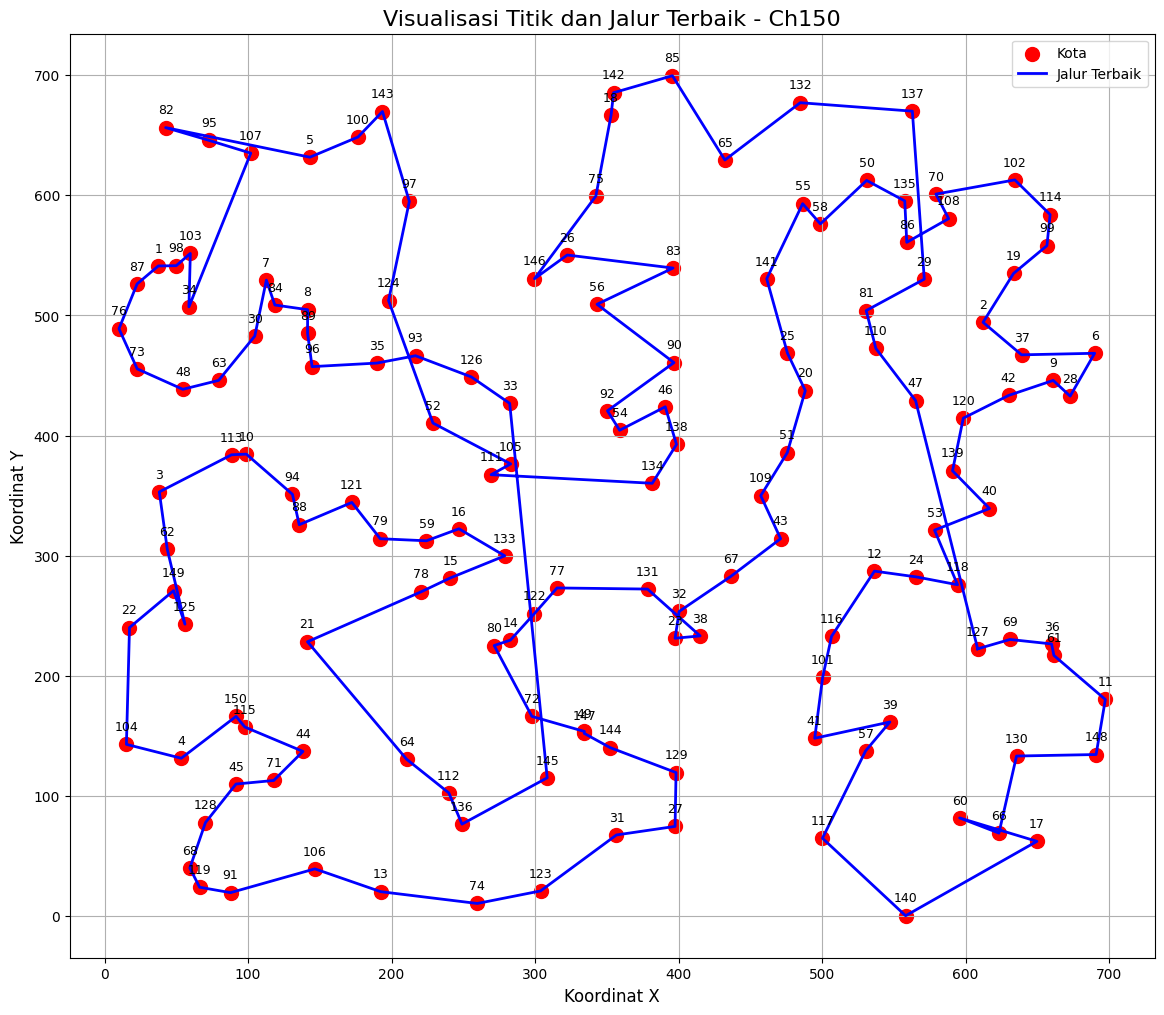

In [17]:
# Visualisasi jalur terbaik untuk masing-masing dataset
visualisasi_titik_dan_jalur(kota_berlin52, solusi_terbaik_akhir_berlin52, "Berlin52")
visualisasi_titik_dan_jalur(kota_kroa100, solusi_terbaik_akhir_kroa100, "KroA100")
visualisasi_titik_dan_jalur(kota_ch150, solusi_terbaik_akhir_ch150, "Ch150")